<a href="https://colab.research.google.com/github/aidannguyen23/Galaxy-Classification/blob/main/GalaxyZooClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

#Read and Clean Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv')
df.head() #shows the first 5 rows

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
0,587727178986356823,00:00:00.41,-10:22:25.7,59,0.610,0.034,0.000,0.153,0.153,0.051,0.186,0.610,0.186,0,0,1
1,587727227300741210,00:00:00.74,-09:13:20.2,18,0.611,0.000,0.167,0.222,0.000,0.000,0.389,0.203,0.797,1,0,0
2,587727225153257596,00:00:01.03,-10:56:48.0,68,0.735,0.029,0.000,0.147,0.074,0.015,0.176,0.432,0.428,0,0,1
3,587730774962536596,00:00:01.38,+15:30:35.3,52,0.885,0.019,0.000,0.058,0.019,0.019,0.077,0.885,0.077,0,1,0
4,587731186203885750,00:00:01.55,-00:05:33.3,59,0.712,0.000,0.000,0.220,0.068,0.000,0.220,0.640,0.290,0,0,1


In [4]:
df = df.drop(["OBJID", "NVOTE", "RA", "DEC"], axis=1)
df['CLASS'] = 0

In [5]:
def combine_classes(row):
    if row["SPIRAL"] == 1:
        return 1
    elif row["ELLIPTICAL"] == 1:
        return 2
    elif row["UNCERTAIN"] == 1:
        return 3
    else:
        return None  # Incase, Return None for rows that don't match any condition

# Spiral = 1
# Elliptical = 2
# Uncertain = 3

df["CLASS"] = df.apply(combine_classes, axis=1)
df = df.drop(["SPIRAL", "ELLIPTICAL", "UNCERTAIN"], axis=1)

# Visualize Variables

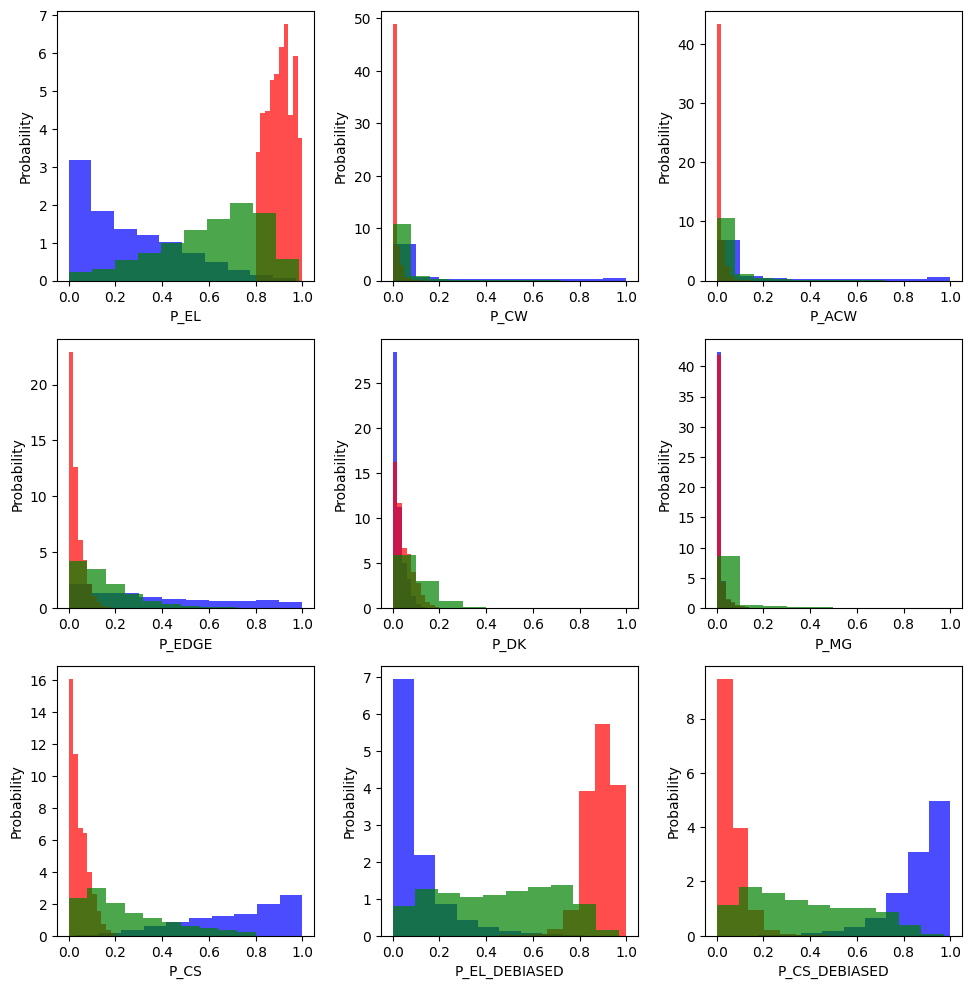

Spiral = Blue
Elliptic = Red
Uncertain = Green


In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i, label in enumerate(df.columns[:9]):
    col = i % 3
    row = i // 3
    axs[row, col].hist(df[df["CLASS"] == 1][label], color='blue', label='galaxyvar1', alpha=0.7, density=True)
    axs[row, col].hist(df[df["CLASS"] == 2][label], color='red', label='galaxyvar2', alpha=0.7, density=True)
    axs[row, col].hist(df[df["CLASS"] == 3][label], color='green', label='galaxyvar3', alpha=0.7, density=True)
    axs[row, col].set_ylabel("Probability")
    axs[row, col].set_xlabel(label)
    plt.gca().set_aspect('auto')  # Set the aspect ratio to be equal

plt.tight_layout()
plt.show()

print("Spiral = Blue")
print("Elliptic = Red")
print("Uncertain = Green")

# Shuffle and Split the Data

In [7]:
print('Number of Spiral Galaxies: ' + str(df['CLASS'].value_counts()[1]))
print('Number of Elliptical Galaxies: ' + str(df['CLASS'].value_counts()[2]))
print('Number of Uncertain Galaxies: ' + str(df['CLASS'].value_counts()[3]))

Number of Spiral Galaxies: 190225
Number of Elliptical Galaxies: 62190
Number of Uncertain Galaxies: 415529


In [8]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame

# Splitting the data into train (60%), validation (20%), and test (20%) sets
train, temp = train_test_split(df, test_size=0.4, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Displaying the lengths of train, validation, and test sets
print(f"Train set length: {len(train)}")
print(f"Validation set length: {len(valid)}")
print(f"Test set length: {len(test)}")


Train set length: 400766
Validation set length: 133589
Test set length: 133589


In [9]:
# Rescale the numbers in the columns
def scale_dataset(dataframe, oversample = False):

  x = dataframe[dataframe.columns[:-1]].values  # Selects all feature columns
  y = dataframe[dataframe.columns[-1]].values   # Selects the target column

# 'x' will contain the feature values (input variables)
# 'y' will contain the corresponding target values
  # take x and fit the standard scalar to x and then transform all of the values
  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  # There are a lot less Spiral and Eliptical than Unknown so have to make it more equal by
  # sampling more from the smaller datasets
  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  # create the whole data as a 2D numpy array
  # take an array and another array and stack them together
  # however y is not 2D so we have to make it 2D
  data = np.hstack((x, np.reshape(y,(-1,1))))
  return data, x, y

In [10]:
# Only want to oversample the training set because the other two are meant to model the real thing
train, x_train, y_train = scale_dataset(train, oversample = True)
valid, x_valid, y_valid = scale_dataset(valid, oversample = False)
test, x_test, y_test = scale_dataset(test, oversample = False)

#K-Nearest Neighbors Model
Defines a distance function (Euclidean), just a straight line, to all of the other points from the training set (distance formula) and takes the label of the majority closest neighbors.

k: the number of nearest neighbors we use to classify Take the form of the majority

This can also be used for higher dimensions.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
# change number of neighbors k
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [13]:
y_pred = knn_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.91      0.85     37798
           2       0.72      0.88      0.79     12398
           3       0.93      0.85      0.89     83393

    accuracy                           0.87    133589
   macro avg       0.82      0.88      0.84    133589
weighted avg       0.88      0.87      0.87    133589



#Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

In [15]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)

In [16]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.89      0.84     37798
           2       0.46      0.97      0.62     12398
           3       0.93      0.72      0.81     83393

    accuracy                           0.79    133589
   macro avg       0.73      0.86      0.76    133589
weighted avg       0.85      0.79      0.80    133589



#Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
lg_model = LogisticRegression(max_iter=1000)
lg_model = lg_model.fit(x_train, y_train)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.89      0.84     37798
           2       0.46      0.97      0.62     12398
           3       0.93      0.72      0.81     83393

    accuracy                           0.79    133589
   macro avg       0.73      0.86      0.76    133589
weighted avg       0.85      0.79      0.80    133589

